In [17]:
# ============================================================
# 1. 환경 설정
# ============================================================

# --- 1.1: 필수 라이브러리 임포트 ---
# 데이터 처리, 시각화, 딥러닝 관련 라이브러리를 한 번에 임포트

import os  # 운영체제 인터페이스 (파일/디렉토리 작업)
import random  # 난수 생성 (데이터 셔플링, 시드 설정)
import numpy as np  # 수치 계산 및 배열 연산
from pathlib import Path  # 객체 지향적 파일 시스템 경로 처리
from collections import defaultdict  # 기본값이 있는 딕셔너리 (히스토리 저장용)

import matplotlib.pyplot as plt  # 데이터 시각화 및 플롯 생성
from PIL import Image  # 이미지 파일 읽기/쓰기
from tqdm.auto import tqdm  # 진행률 표시줄 (훈련/검증 진행 상황)

# PyTorch 핵심 모듈
import torch  # PyTorch 메인 라이브러리
import torch.nn as nn  # 신경망 레이어 및 손실 함수
import torch.optim as optim  # 최적화 알고리즘 (Adam, SGD 등)
from torch.utils.data import Dataset, DataLoader  # 데이터셋/데이터로더
from torch.amp import autocast, GradScaler  # 혼합 정밀도 훈련 (Mixed Precision)

# PyTorch Vision 모듈
from torchvision import models, transforms  # 사전학습 모델 및 이미지 변환

# 머신러닝 유틸리티
from sklearn.model_selection import train_test_split  # 데이터 분할 (Train/Val split)
import copy  # 객체 깊은 복사 (모델 가중치 저장)

print("=" * 70)
print("1.1: 라이브러리 임포트 완료")
print("=" * 70)
print(f"  - PyTorch 버전: {torch.__version__}")
print(f"  - CUDA 사용 가능: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"  - GPU: {torch.cuda.get_device_name(0)}")
print()

1.1: 라이브러리 임포트 완료
  - PyTorch 버전: 2.7.1+cu118
  - CUDA 사용 가능: True
  - GPU: NVIDIA GeForce RTX 4070 Ti



In [18]:
# --- 1.2: 주요 상수 및 환경 설정 ---
# 재현성을 위한 시드와 실행 디바이스 설정

SEED = 42  # 랜덤 시드 (실험 재현성 확보)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # GPU/CPU 자동 선택

print("=" * 70)
print("1.2: 주요 상수 정의 완료")
print("=" * 70)
print(f"  - 랜덤 시드: {SEED}")
print(f"  - 실행 디바이스: {DEVICE}")
if torch.cuda.is_available():
    print(f"  - GPU 메모리: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
    print(f"  - GPU 이름: {torch.cuda.get_device_name(0)}")
print()

# --- 1.3: 재현성을 위한 랜덤 시드 고정 + GPU 최적화 ---
# 모든 랜덤 생성기의 시드를 고정하고 GPU 최적화 설정

random.seed(SEED)  # Python 기본 random 모듈
np.random.seed(SEED)  # NumPy random
torch.manual_seed(SEED)  # PyTorch CPU

if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)  # PyTorch GPU (모든 GPU)
    
    # GPU 최적화 설정
    torch.backends.cudnn.benchmark = True  # 입력 크기가 일정할 때 최적 알고리즘 자동 선택
    torch.backends.cudnn.deterministic = False  # 성능 우선 (약간의 비결정성 허용)
    torch.backends.cudnn.enabled = True  # cuDNN 활성화
    
    # TensorFloat-32 활성화 (Ampere 이상 GPU에서 자동 성능 향상)
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True
    
    print("=" * 70)
    print("1.3: 재현성 시드 고정 + GPU 최적화 완료")
    print("=" * 70)
    print("  [랜덤 시드 설정]")
    print("    - Python random 시드 고정")
    print("    - NumPy random 시드 고정")
    print("    - PyTorch CPU/GPU 시드 고정")
    print()
    print("  [GPU 최적화 설정]")
    print("    - cuDNN Benchmark: True (최적 알고리즘 자동 선택)")
    print("    - cuDNN Deterministic: False (성능 우선)")
    print("    - TF32 활성화: True (Ampere+ GPU 성능 향상)")
    print("    → GPU 사용률 및 속도 대폭 향상!")
else:
    print("=" * 70)
    print("1.3: 재현성 시드 고정 완료 (CPU 모드)")
    print("=" * 70)
    print("  - Python random 시드 고정")
    print("  - NumPy random 시드 고정")
    print("  - PyTorch CPU 시드 고정")

print("=" * 70)
print()

1.2: 주요 상수 정의 완료
  - 랜덤 시드: 42
  - 실행 디바이스: cuda
  - GPU 메모리: 12.0 GB
  - GPU 이름: NVIDIA GeForce RTX 4070 Ti

1.3: 재현성 시드 고정 + GPU 최적화 완료
  [랜덤 시드 설정]
    - Python random 시드 고정
    - NumPy random 시드 고정
    - PyTorch CPU/GPU 시드 고정

  [GPU 최적화 설정]
    - cuDNN Benchmark: True (최적 알고리즘 자동 선택)
    - cuDNN Deterministic: False (성능 우선)
    - TF32 활성화: True (Ampere+ GPU 성능 향상)
    → GPU 사용률 및 속도 대폭 향상!



In [19]:
# ============================================================
# 2. 데이터 로딩 및 전처리
# ============================================================

# --- 2.1: 데이터셋 경로 설정 및 검증 ---
# dataset_path.txt에서 Food-101 데이터셋 경로를 읽어와 검증

try:
    # 텍스트 파일에서 데이터셋 루트 경로 읽기
    # 노트북이 notebooks/ 폴더에 있으므로 ../data/ 경로 사용
    dataset_path_file = Path("../data/dataset_path.txt")
    
    with open(dataset_path_file, "r") as f:
        base_path = Path(f.read().strip())
    
    # Food-101 데이터셋 구조: base_path/food-101/food-101/{images, meta}
    DATA_ROOT = base_path / "food-101" / "food-101"
    IMAGES_DIR = DATA_ROOT / "images"  # 이미지 파일들이 저장된 디렉토리
    META_DIR = DATA_ROOT / "meta"  # 메타데이터 파일들 (클래스 목록, train/test split)
    
    # 경로 존재 여부 확인
    assert IMAGES_DIR.exists(), f"이미지 디렉토리가 존재하지 않습니다: {IMAGES_DIR}"
    assert META_DIR.exists(), f"메타 디렉토리가 존재하지 않습니다: {META_DIR}"
    
    print("=" * 70)
    print("2.1: 데이터셋 경로 설정 완료")
    print("=" * 70)
    print(f"  - 데이터셋 경로 파일: {dataset_path_file}")
    print(f"  - 데이터 루트: {DATA_ROOT}")
    print(f"  - 이미지 디렉토리: {IMAGES_DIR}")
    print(f"  - 메타 디렉토리: {META_DIR}")
    print(f"  - 경로 검증: 통과")
    print()
    
except FileNotFoundError:
    print("=" * 70)
    print("오류: dataset_path.txt 파일을 찾을 수 없습니다!")
    print("=" * 70)
    print(f"  - 찾는 위치: {Path('../data/dataset_path.txt').absolute()}")
    print()
    print("  해결 방법:")
    print("  1. 데이터셋을 다운로드했는지 확인하세요:")
    print("     python ../scripts/download_dataset.py")
    print()
    print("  2. dataset_path.txt가 올바른 위치에 있는지 확인하세요:")
    print("     경로: /root/llm_prj/data/dataset_path.txt")
    print("=" * 70)
    raise
except AssertionError as e:
    print("=" * 70)
    print(f"오류: {e}")
    print("=" * 70)
    print("  데이터셋 경로를 확인하세요.")
    print("  Food-101 데이터셋이 올바르게 다운로드되었는지 확인하세요.")
    print("=" * 70)
    raise

2.1: 데이터셋 경로 설정 완료
  - 데이터셋 경로 파일: ../data/dataset_path.txt
  - 데이터 루트: /root/.cache/kagglehub/datasets/dansbecker/food-101/versions/1/food-101/food-101
  - 이미지 디렉토리: /root/.cache/kagglehub/datasets/dansbecker/food-101/versions/1/food-101/food-101/images
  - 메타 디렉토리: /root/.cache/kagglehub/datasets/dansbecker/food-101/versions/1/food-101/food-101/meta
  - 경로 검증: 통과



In [20]:
# --- 2.2: 메타데이터 로드 및 매핑 생성 ---
# Food-101 데이터셋의 클래스 정보와 train/test split 정보를 로드

# 1. 클래스 목록 로드 (101개 음식 카테고리)
with open(META_DIR / "classes.txt") as f:
    CLASSES = [line.strip() for line in f]

# 2. 훈련 이미지 경로 목록 (각 클래스당 750장)
with open(META_DIR / "train.txt") as f:
    TRAIN_IMGS = [line.strip() for line in f]

# 3. 테스트 이미지 경로 목록 (각 클래스당 250장)
with open(META_DIR / "test.txt") as f:
    TEST_IMGS = [line.strip() for line in f]

# 4. 클래스명 <-> 인덱스 매핑 딕셔너리 생성
CLASS_TO_IDX = {cls: i for i, cls in enumerate(CLASSES)}  # 'apple_pie' -> 0
IDX_TO_CLASS = {i: cls for cls, i in CLASS_TO_IDX.items()}  # 0 -> 'apple_pie'

print("=" * 70)
print("2.2: 메타데이터 로드 완료")
print("=" * 70)
print(f"  - 총 클래스 수: {len(CLASSES)}개")
print(f"  - 훈련 이미지: {len(TRAIN_IMGS):,}장 (클래스당 750장)")
print(f"  - 테스트 이미지: {len(TEST_IMGS):,}장 (클래스당 250장)")
print(f"  - 총 이미지: {len(TRAIN_IMGS) + len(TEST_IMGS):,}장")
print()
print("  샘플 클래스 (처음 5개):")
for i in range(min(5, len(CLASSES))):
    print(f"    {i:2d}. {CLASSES[i]}")
print("=" * 70)
print()

2.2: 메타데이터 로드 완료
  - 총 클래스 수: 101개
  - 훈련 이미지: 75,750장 (클래스당 750장)
  - 테스트 이미지: 25,250장 (클래스당 250장)
  - 총 이미지: 101,000장

  샘플 클래스 (처음 5개):
     0. apple_pie
     1. baby_back_ribs
     2. baklava
     3. beef_carpaccio
     4. beef_tartare



In [21]:
# --- 2.3: 커스텀 데이터셋 클래스 정의 ---
# PyTorch Dataset 인터페이스를 구현한 Food-101 데이터셋 클래스

class Food101Dataset(Dataset):
    """
    Food-101 데이터셋을 위한 커스텀 Dataset 클래스
    
    PyTorch의 Dataset을 상속받아 다음 메서드를 구현:
    - __init__: 데이터셋 초기화
    - __len__: 데이터셋 크기 반환
    - __getitem__: 인덱스에 해당하는 샘플 반환
    
    Args:
        img_paths (list): 이미지 경로 리스트 (예: ['apple_pie/1234', ...])
        img_dir (Path): 이미지가 저장된 루트 디렉토리
        class_to_idx (dict): 클래스명 -> 인덱스 매핑 딕셔너리
        transform (callable, optional): 이미지 변환 함수
    """
    
    def __init__(self, img_paths, img_dir, class_to_idx, transform=None):
        """데이터셋 초기화"""
        self.img_paths = img_paths  # 이미지 경로 리스트
        self.img_dir = Path(img_dir)  # 이미지 디렉토리
        self.class_to_idx = class_to_idx  # 클래스-인덱스 매핑
        self.transform = transform  # 이미지 변환기

    def __len__(self):
        """데이터셋의 총 샘플 수 반환"""
        return len(self.img_paths)

    def __getitem__(self, idx):
        """
        인덱스에 해당하는 샘플 (이미지, 레이블) 반환
        
        Args:
            idx (int): 샘플 인덱스
            
        Returns:
            tuple: (이미지 텐서, 레이블 인덱스)
        """
        # 1. 이미지 경로에서 클래스명 추출
        path = self.img_paths[idx]  # 예: 'apple_pie/1234'
        class_name = path.split('/')[0]  # 'apple_pie'
        label = self.class_to_idx[class_name]  # 정수 레이블로 변환
        
        # 2. 이미지 로드 및 RGB 변환
        # - JPEG 이미지는 그레이스케일일 수 있으므로 RGB로 통일
        img = Image.open(self.img_dir / f"{path}.jpg").convert('RGB')
        
        # 3. 이미지 변환 적용 (리사이즈, 증강, 정규화 등)
        if self.transform:
            img = self.transform(img)
        
        return img, label

print("=" * 70)
print("2.3: 커스텀 데이터셋 클래스(Food101Dataset) 정의 완료")
print("=" * 70)
print("  - PyTorch Dataset 인터페이스 구현")
print("  - __init__: 데이터셋 초기화")
print("  - __len__: 데이터셋 크기 반환")
print("  - __getitem__: 샘플 로드 및 전처리")
print("=" * 70)
print()

2.3: 커스텀 데이터셋 클래스(Food101Dataset) 정의 완료
  - PyTorch Dataset 인터페이스 구현
  - __init__: 데이터셋 초기화
  - __len__: 데이터셋 크기 반환
  - __getitem__: 샘플 로드 및 전처리



In [22]:
# --- 2.4: 이미지 전처리 설정 (증강 제거) ---
# 훈련/검증 모두 동일한 기본 변환만 적용

# 이미지 크기 및 정규화 파라미터
IMG_SIZE = 224  # ResNet 입력 크기 (224x224)
MEAN = [0.485, 0.456, 0.406]  # ImageNet 정규화 평균 (R, G, B)
STD = [0.229, 0.224, 0.225]  # ImageNet 정규화 표준편차 (R, G, B)

# 훈련 데이터 변환 (증강 제거 - 기본 변환만 적용)
train_transform = transforms.Compose([
    transforms.Resize(256),  # 짧은 변을 256으로 조정 (종횡비 유지)
    transforms.CenterCrop(IMG_SIZE),  # 중앙에서 224x224 크롭
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)
])

# 검증/테스트 데이터 변환 (동일한 변환)
val_transform = transforms.Compose([
    transforms.Resize(256),  # 짧은 변을 256으로 조정 (종횡비 유지)
    transforms.CenterCrop(IMG_SIZE),  # 중앙에서 224x224 크롭
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)
])

print("=" * 70)
print("2.4: 이미지 전처리 설정 완료 (증강 제거)")
print("=" * 70)
print(f"  - 입력 이미지 크기: {IMG_SIZE}x{IMG_SIZE}")
print(f"  - 정규화 평균 (RGB): {MEAN}")
print(f"  - 정규화 표준편차 (RGB): {STD}")
print()
print("  [훈련용 변환 - 증강 제거]")
print("    1. Resize (크기 조정)")
print("    2. CenterCrop (중앙 크롭)")
print("    3. ToTensor (텐서 변환)")
print("    4. Normalize (정규화)")
print()
print("  [검증/테스트용 변환]")
print("    1. Resize (크기 조정)")
print("    2. CenterCrop (중앙 크롭)")
print("    3. ToTensor (텐서 변환)")
print("    4. Normalize (정규화)")
print()
print("  ※ 데이터 증강 제거 - 하이퍼파라미터 최적화에 집중")
print("=" * 70)
print()

2.4: 이미지 전처리 설정 완료 (증강 제거)
  - 입력 이미지 크기: 224x224
  - 정규화 평균 (RGB): [0.485, 0.456, 0.406]
  - 정규화 표준편차 (RGB): [0.229, 0.224, 0.225]

  [훈련용 변환 - 증강 제거]
    1. Resize (크기 조정)
    2. CenterCrop (중앙 크롭)
    3. ToTensor (텐서 변환)
    4. Normalize (정규화)

  [검증/테스트용 변환]
    1. Resize (크기 조정)
    2. CenterCrop (중앙 크롭)
    3. ToTensor (텐서 변환)
    4. Normalize (정규화)

  ※ 데이터 증강 제거 - 하이퍼파라미터 최적화에 집중



In [23]:
# --- 2.5: 데이터 증강 제거 안내 ---
# 이 프로젝트에서는 하이퍼파라미터 최적화에 집중하기 위해 데이터 증강을 사용하지 않습니다.

print("=" * 70)
print("2.5: 데이터 증강 제거")
print("=" * 70)
print("  - 데이터 증강을 사용하지 않고 기본 전처리만 적용합니다.")
print("  - 에폭 수와 학습률 최적화에 집중합니다.")
print("=" * 70)
print()

2.5: 데이터 증강 제거
  - 데이터 증강을 사용하지 않고 기본 전처리만 적용합니다.
  - 에폭 수와 학습률 최적화에 집중합니다.



In [38]:
# --- 2.6: 데이터 분할 (훈련/검증) ---
# 훈련 데이터를 Train/Validation으로 분할하고 Dataset 객체 생성

VAL_SPLIT = 0.2  # 검증 세트 비율 (20%)

# stratify 옵션으로 각 클래스 비율을 유지하면서 분할
train_list, val_list = train_test_split(
    TRAIN_IMGS,
    test_size=VAL_SPLIT,  # 20%를 검증용으로 사용
    random_state=SEED,  # 재현성을 위한 시드
    stratify=[x.split('/')[0] for x in TRAIN_IMGS]  # 클래스 비율 유지
)

# Dataset 객체 생성
train_ds = Food101Dataset(train_list, IMAGES_DIR, CLASS_TO_IDX, train_transform)
val_ds = Food101Dataset(val_list, IMAGES_DIR, CLASS_TO_IDX, val_transform)
test_ds = Food101Dataset(TEST_IMGS, IMAGES_DIR, CLASS_TO_IDX, val_transform)

print("=" * 70)
print("2.6: 데이터 분할 및 Dataset 생성 완료")
print("=" * 70)
print(f"  - 원본 훈련 데이터: {len(TRAIN_IMGS):,}장")
print(f"  - 분할 후:")
print(f"    - 훈련: {len(train_ds):,}장 ({len(train_ds)/len(TRAIN_IMGS)*100:.1f}%)")
print(f"    - 검증: {len(val_ds):,}장 ({len(val_ds)/len(TRAIN_IMGS)*100:.1f}%)")
print(f"  - 테스트: {len(test_ds):,}장")
print()
print(f"  - 클래스 비율 유지: 각 클래스의 비율이 Train/Val에서 동일")
print(f"  - 데이터 증강: 훈련 데이터에만 적용")
print("=" * 70)
print()

2.6: 데이터 분할 및 Dataset 생성 완료
  - 원본 훈련 데이터: 75,750장
  - 분할 후:
    - 훈련: 60,600장 (80.0%)
    - 검증: 15,150장 (20.0%)
  - 테스트: 25,250장

  - 클래스 비율 유지: 각 클래스의 비율이 Train/Val에서 동일
  - 데이터 증강: 훈련 데이터에만 적용



In [ ]:
# --- 2.7: DataLoader 생성 (GPU 최적화) ---
# GPU 효율성을 극대화하기 위한 DataLoader 설정

BATCH_SIZE = 256  # 배치 크기를 대폭 증가 (GPU 활용 극대화)
NUM_WORKERS = 8  # 데이터 로딩을 위한 CPU 워커 프로세스 수 증가

# DataLoader 공통 파라미터
loader_params = {
    'batch_size': BATCH_SIZE,
    'num_workers': NUM_WORKERS,
    'pin_memory': True if DEVICE.type == 'cuda' else False,  # GPU 사용 시 메모리 고정
    'persistent_workers': True if NUM_WORKERS > 0 else False,  # 워커 프로세스 재사용
    'prefetch_factor': 4 if NUM_WORKERS > 0 else None,  # 각 워커가 미리 로드할 배치 수
    'drop_last': True  # 마지막 불완전한 배치 제거 (GPU 효율성)
}

# 각 데이터셋에 대한 DataLoader 생성
train_loader = DataLoader(
    train_ds, 
    shuffle=True,  # 훈련 데이터는 매 에폭마다 셔플
    **loader_params
)

val_loader = DataLoader(
    val_ds, 
    shuffle=False,  # 검증 데이터는 순서 유지
    **loader_params
)

test_loader = DataLoader(
    test_ds, 
    shuffle=False,  # 테스트 데이터는 순서 유지
    **loader_params
)

print("=" * 70)
print("2.7: DataLoader 생성 완료 (GPU 최적화)")
print("=" * 70)
print(f"  - 배치 크기: {BATCH_SIZE} (GPU 활용 극대화)")
print(f"  - CPU 워커 수: {NUM_WORKERS}")
print(f"  - Pin Memory: {loader_params['pin_memory']}")
print(f"  - Persistent Workers: {loader_params['persistent_workers']}")
print(f"  - Prefetch Factor: {loader_params['prefetch_factor']}")
print(f"  - Drop Last: {loader_params['drop_last']}")
print()
print(f"  [훈련 DataLoader]")
print(f"    - 총 배치 수: {len(train_loader)}")
print(f"    - 샘플 수: {len(train_ds):,}장")
print(f"    - 셔플: 활성화")
print()
print(f"  [검증 DataLoader]")
print(f"    - 총 배치 수: {len(val_loader)}")
print(f"    - 샘플 수: {len(val_ds):,}장")
print(f"    - 셔플: 비활성화")
print()
print(f"  [테스트 DataLoader]")
print(f"    - 총 배치 수: {len(test_loader)}")
print(f"    - 샘플 수: {len(test_ds):,}장")
print(f"    - 셔플: 비활성화")
print()
print("  ※ GPU 사용률 최적화:")
print("    - 큰 배치 크기로 GPU 활용도 증가")
print("    - 다중 워커로 데이터 로딩 병목 제거")
print("    - Prefetch로 GPU가 데이터를 기다리지 않도록 설정")
print("=" * 70)
print()

In [46]:
# ============================================================
# 3. 모델 구성
# ============================================================

# --- 3.1: 전이학습 기반 모델 생성 함수 ---
# ImageNet으로 사전학습된 ResNet18을 Food-101 분류기로 변환

def get_model(num_classes):
    """
    전이학습 기반 ResNet18 모델 생성
    
    전이학습(Transfer Learning):
    - ImageNet으로 사전학습된 가중치 사용
    - 마지막 분류 레이어만 Food-101 클래스 수에 맞게 교체
    - 사전학습된 특성 추출기를 활용하여 적은 데이터로도 높은 성능 달성
    
    Args:
        num_classes (int): 출력 클래스 수 (Food-101의 경우 101)
    
    Returns:
        torch.nn.Module: GPU/CPU로 이동된 모델
    """
    # 1. ImageNet 사전학습 가중치로 ResNet18 로드
    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    
    # 2. 마지막 FC(Fully Connected) 레이어 교체
    #    - 원본: 512 -> 1000 (ImageNet 클래스 수)
    #    - 수정: 512 -> 101 (Food-101 클래스 수)
    num_features = model.fc.in_features  # ResNet18의 경우 512
    model.fc = nn.Linear(num_features, num_classes)
    
    # 3. 모델을 지정된 디바이스(GPU/CPU)로 이동
    return model.to(DEVICE)

print("=" * 70)
print("3.1: 모델 생성 함수 정의 완료")
print("=" * 70)
print("  - 베이스 모델: ResNet18")
print("  - 사전학습 가중치: ImageNet-1K")
print("  - 전이학습: 마지막 FC 레이어만 재학습")
print("=" * 70)
print()

3.1: 모델 생성 함수 정의 완료
  - 베이스 모델: ResNet18
  - 사전학습 가중치: ImageNet-1K
  - 전이학습: 마지막 FC 레이어만 재학습



In [47]:
# --- 3.2: 학습 요소 설정 안내 ---
# 각 실험마다 새로운 모델, 옵티마이저, 스케줄러를 생성합니다.

print("=" * 70)
print("3.2: 학습 요소 설정")
print("=" * 70)
print()
print("[모델 구조]")
print("  - 모델: ResNet18")
print("  - 입력 크기: (3, 224, 224)")
print("  - 출력 클래스: 101개")
print("  - 총 파라미터: 약 11,176,512개")
print()
print("[학습 설정]")
print("  - 손실 함수: CrossEntropyLoss")
print("  - 옵티마이저: Adam")
print("  - Weight Decay: 1e-4")
print("  - 스케줄러: ReduceLROnPlateau")
print("    - Mode: max (정확도 최대화)")
print("    - Factor: 0.5")
print("    - Patience: 2 epochs")
print("  - Mixed Precision: 활성화")
print()
print("  ※ 각 실험마다 모델과 옵티마이저를 새로 초기화합니다.")
print("=" * 70)
print()

3.2: 학습 요소 설정

[모델 구조]
  - 모델: ResNet18
  - 입력 크기: (3, 224, 224)
  - 출력 클래스: 101개
  - 총 파라미터: 약 11,176,512개

[학습 설정]
  - 손실 함수: CrossEntropyLoss
  - 옵티마이저: Adam
  - Weight Decay: 1e-4
  - 스케줄러: ReduceLROnPlateau
    - Mode: max (정확도 최대화)
    - Factor: 0.5
    - Patience: 2 epochs
  - Mixed Precision: 활성화

  ※ 각 실험마다 모델과 옵티마이저를 새로 초기화합니다.



In [48]:
# ============================================================
# 4. 훈련 및 검증
# ============================================================

# --- 4.1: 훈련 및 검증 함수 정의 (GPU 최적화) ---
# 에폭별 훈련과 검증을 수행하는 함수

def train_epoch(model, loader, criterion, optimizer, scaler, device):
    """
    1 에폭 훈련 함수 (Mixed Precision Training + GPU 최적화)
    
    Args:
        model: 훈련할 모델
        loader: 훈련 데이터 로더
        criterion: 손실 함수
        optimizer: 옵티마이저
        scaler: 혼합 정밀도 스케일러
        device: 연산 디바이스 (cuda/cpu)
    
    Returns:
        tuple: (평균 손실, 정확도)
    """
    model.train()  # 훈련 모드 활성화
    
    total_loss = 0.0
    correct = 0
    total = 0
    
    # 진행률 표시줄 (업데이트 빈도 조정으로 오버헤드 감소)
    progress_bar = tqdm(loader, desc='Training', leave=False, 
                        mininterval=1.0,  # 최소 1초마다 업데이트
                        maxinterval=5.0)  # 최대 5초마다 업데이트
    
    for batch_idx, (images, labels) in enumerate(progress_bar):
        # 데이터를 디바이스로 이동 (non_blocking으로 비동기 전송)
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        
        # 그래디언트 초기화
        optimizer.zero_grad(set_to_none=True)  # set_to_none=True로 메모리 효율 향상
        
        # 순전파 (혼합 정밀도)
        with autocast(device_type=device.type, enabled=torch.cuda.is_available()):
            outputs = model(images)
            loss = criterion(outputs, labels)
        
        # 역전파
        scaler.scale(loss).backward()
        
        # 가중치 업데이트
        scaler.step(optimizer)
        scaler.update()
        
        # 통계 업데이트 (GPU에서 직접 계산)
        total_loss += loss.item() * images.size(0)
        _, preds = outputs.max(1)
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)
        
        # 진행률 표시줄 업데이트 (10 배치마다만 업데이트로 오버헤드 감소)
        if batch_idx % 10 == 0:
            progress_bar.set_postfix(
                loss=f"{loss.item():.4f}", 
                acc=f"{100*correct/total:.2f}%"
            )
    
    return total_loss / total, 100.0 * correct / total


def validate(model, loader, criterion, device):
    """
    검증/테스트 함수 (GPU 최적화)
    
    Args:
        model: 평가할 모델
        loader: 검증/테스트 데이터 로더
        criterion: 손실 함수
        device: 연산 디바이스
    
    Returns:
        tuple: (평균 손실, 정확도)
    """
    model.eval()  # 평가 모드
    
    total_loss = 0.0
    correct = 0
    total = 0
    
    # 그래디언트 계산 비활성화
    with torch.no_grad():
        progress_bar = tqdm(loader, desc='Validation', leave=False,
                           mininterval=1.0, maxinterval=5.0)
        
        for batch_idx, (images, labels) in enumerate(progress_bar):
            # 비동기 전송
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            
            # 순전파 (혼합 정밀도)
            with autocast(device_type=device.type, enabled=torch.cuda.is_available()):
                outputs = model(images)
                loss = criterion(outputs, labels)
            
            # 통계 업데이트
            total_loss += loss.item() * images.size(0)
            _, preds = outputs.max(1)
            correct += preds.eq(labels).sum().item()
            total += labels.size(0)
            
            # 10 배치마다만 업데이트
            if batch_idx % 10 == 0:
                progress_bar.set_postfix(
                    loss=f"{loss.item():.4f}", 
                    acc=f"{100*correct/total:.2f}%"
                )
    
    return total_loss / total, 100.0 * correct / total

print("=" * 70)
print("4.1: 훈련 및 검증 함수 정의 완료 (GPU 최적화)")
print("=" * 70)
print()
print("[train_epoch 함수 - 최적화]")
print("  - non_blocking=True: 비동기 GPU 전송")
print("  - zero_grad(set_to_none=True): 메모리 효율")
print("  - 진행률 표시 최소화: 오버헤드 감소")
print("  - Mixed Precision Training")
print()
print("[validate 함수 - 최적화]")
print("  - no_grad() 컨텍스트: 메모리 절약")
print("  - 비동기 전송")
print("  - Mixed Precision")
print("=" * 70)
print()

4.1: 훈련 및 검증 함수 정의 완료 (GPU 최적화)

[train_epoch 함수 - 최적화]
  - non_blocking=True: 비동기 GPU 전송
  - zero_grad(set_to_none=True): 메모리 효율
  - 진행률 표시 최소화: 오버헤드 감소
  - Mixed Precision Training

[validate 함수 - 최적화]
  - no_grad() 컨텍스트: 메모리 절약
  - 비동기 전송
  - Mixed Precision



In [ ]:
# --- 4.2: 최적 하이퍼파라미터 설정 ---
# 하이퍼파라미터 탐색으로 찾은 최적 파라미터로 훈련

# 최적 하이퍼파라미터 (실험 결과: Exp5가 최고 성능 64.23%)
hyperparameter_configs = [
    {'epochs': 10, 'lr': 5e-4, 'name': 'Optimal: 10ep_lr5e-4'},  # 최적 파라미터
]

# 전체 실험 결과를 저장할 리스트
all_experiments = []

print("=" * 70)
print("4.2: 최적 하이퍼파라미터 설정 (GPU 최적화)")
print("=" * 70)
print(f"  - 에폭: 10")
print(f"  - 학습률: 5e-4 (0.0005)")
print(f"  - 배치 크기: {BATCH_SIZE} (GPU 최대 활용)")
print()
print("  [최적 파라미터 선택 이유]")
print("    - 이전 실험에서 최고 검증 정확도 64.23% 달성")
print("    - 에폭 8에서 최고 성능 기록")
print("    - 낮은 학습률로 안정적인 학습")
print()
print("  ※ GPU 최적화로 빠른 훈련 속도!")
print("=" * 70)
print()

In [50]:
# --- 4.3: 하이퍼파라미터 탐색 실험 실행 ---
# 여러 설정으로 훈련을 반복하여 최적의 파라미터 찾기

import time

print("=" * 70)
print("4.3: 하이퍼파라미터 탐색 시작")
print("=" * 70)
print()

# 각 설정에 대해 실험 수행
for exp_idx, config in enumerate(hyperparameter_configs, 1):
    print("=" * 70)
    print(f"실험 {exp_idx}/{len(hyperparameter_configs)}: {config['name']}")
    print("=" * 70)
    print(f"  - 에폭: {config['epochs']}")
    print(f"  - 학습률: {config['lr']}")
    print()
    
    # 실험 시작 시간
    exp_start_time = time.time()
    
    # 1. 새로운 모델 생성 (매 실험마다 초기화)
    model = get_model(len(CLASSES))
    
    # 2. 손실 함수
    criterion = nn.CrossEntropyLoss()
    
    # 3. 옵티마이저 (설정된 학습률 사용)
    optimizer = optim.Adam(
        model.parameters(), 
        lr=config['lr'],
        weight_decay=1e-4
    )
    
    # 4. 학습률 스케줄러
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        mode='max',
        factor=0.5,
        patience=2
    )
    
    # 5. Mixed Precision 스케일러
    scaler = GradScaler(enabled=torch.cuda.is_available())
    
    # 히스토리 및 최고 모델 저장용 변수
    history = defaultdict(list)
    best_acc = 0.0
    best_epoch = 0
    best_model_state = None
    
    # 에폭 반복
    EPOCHS = config['epochs']
    for epoch in range(EPOCHS):
        # 훈련
        train_loss, train_acc = train_epoch(
            model, train_loader, criterion, optimizer, scaler, DEVICE
        )
        
        # 검증
        val_loss, val_acc = validate(
            model, val_loader, criterion, DEVICE
        )
        
        # 히스토리 저장
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        # 학습률 스케줄러 업데이트
        scheduler.step(val_acc)
        
        # 에폭 결과 출력
        print(f"  [에폭 {epoch+1:02d}/{EPOCHS}] "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
        
        # 최고 모델 저장
        if val_acc > best_acc:
            best_acc = val_acc
            best_epoch = epoch + 1
            best_model_state = copy.deepcopy(model.state_dict())
    
    # 실험 종료 시간
    exp_elapsed = time.time() - exp_start_time
    
    # 실험 결과 저장
    experiment_result = {
        'name': config['name'],
        'epochs': config['epochs'],
        'lr': config['lr'],
        'best_val_acc': best_acc,
        'best_epoch': best_epoch,
        'final_train_acc': history['train_acc'][-1],
        'final_val_acc': history['val_acc'][-1],
        'history': history,
        'best_model_state': best_model_state,
        'elapsed_time': exp_elapsed
    }
    all_experiments.append(experiment_result)
    
    print()
    print(f"  [실험 {exp_idx} 완료]")
    print(f"    - 최고 검증 정확도: {best_acc:.2f}% (에폭 {best_epoch})")
    print(f"    - 최종 훈련 정확도: {history['train_acc'][-1]:.2f}%")
    print(f"    - 소요 시간: {exp_elapsed/60:.1f}분")
    print()
    
    # 메모리 정리
    del model, optimizer, scheduler, scaler
    torch.cuda.empty_cache()

print("=" * 70)
print("모든 실험 완료!")
print("=" * 70)

4.3: 하이퍼파라미터 탐색 시작

실험 1/5: Exp1: 3ep_lr1e-3
  - 에폭: 3
  - 학습률: 0.001



Training:   0%|          | 0/1894 [00:00<?, ?it/s]

Validation:   0%|          | 0/474 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f10dbf88af0>
Traceback (most recent call last):
  File "/root/miniconda3/envs/food101/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/root/miniconda3/envs/food101/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    if w.is_alive():
  File "/root/miniconda3/envs/food101/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


  [에폭 01/3] Train Loss: 2.8405, Train Acc: 31.08% | Val Loss: 2.4511, Val Acc: 39.76%


Training:   0%|          | 0/1894 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f10dbf88af0>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f10dbf88af0>Traceback (most recent call last):
  File "/root/miniconda3/envs/food101/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__

Traceback (most recent call last):
    self._shutdown_workers()  File "/root/miniconda3/envs/food101/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__

      File "/root/miniconda3/envs/food101/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
self._shutdown_workers()    
if w.is_alive():  File "/root/miniconda3/envs/food101/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers

      File "/root/miniconda3/envs/food101/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
if w.is_alive():    
  File "/root/miniconda3/envs/food

Validation:   0%|          | 0/474 [00:00<?, ?it/s]

  [에폭 02/3] Train Loss: 2.0397, Train Acc: 47.83% | Val Loss: 2.2708, Val Acc: 43.49%


Training:   0%|          | 0/1894 [00:00<?, ?it/s]

Validation:   0%|          | 0/474 [00:00<?, ?it/s]

  [에폭 03/3] Train Loss: 1.7336, Train Acc: 54.93% | Val Loss: 1.8968, Val Acc: 51.37%

  [실험 1 완료]
    - 최고 검증 정확도: 51.37% (에폭 3)
    - 최종 훈련 정확도: 54.93%
    - 소요 시간: 5.3분

실험 2/5: Exp2: 5ep_lr1e-3
  - 에폭: 5
  - 학습률: 0.001



Training:   0%|          | 0/1894 [00:00<?, ?it/s]

Validation:   0%|          | 0/474 [00:00<?, ?it/s]

  [에폭 01/5] Train Loss: 2.8708, Train Acc: 30.25% | Val Loss: 2.4320, Val Acc: 40.43%


Training:   0%|          | 0/1894 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f10dbf88af0>
Traceback (most recent call last):
  File "/root/miniconda3/envs/food101/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/root/miniconda3/envs/food101/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    if w.is_alive():
  File "/root/miniconda3/envs/food101/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f10dbf88af0>
Traceback (most recent call last):
  File "/root/miniconda3/envs/food101/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/root/miniconda3/envs/food101/lib/python3.10/site-packages/to

Validation:   0%|          | 0/474 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f10dbf88af0><function _MultiProcessingDataLoaderIter.__del__ at 0x7f10dbf88af0>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/root/miniconda3/envs/food101/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
  File "/root/miniconda3/envs/food101/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()    
self._shutdown_workers()  File "/root/miniconda3/envs/food101/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers

  File "/root/miniconda3/envs/food101/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    if w.is_alive():    if w.is_alive():

  File "/root/miniconda3/envs/food101/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
  File "/root/miniconda3/envs/food101/

  [에폭 02/5] Train Loss: 2.0641, Train Acc: 47.43% | Val Loss: 2.0973, Val Acc: 47.08%


Training:   0%|          | 0/1894 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f10dbf88af0><function _MultiProcessingDataLoaderIter.__del__ at 0x7f10dbf88af0>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/root/miniconda3/envs/food101/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
  File "/root/miniconda3/envs/food101/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
        self._shutdown_workers()self._shutdown_workers()

  File "/root/miniconda3/envs/food101/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
  File "/root/miniconda3/envs/food101/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
        if w.is_alive():if w.is_alive():

  File "/root/miniconda3/envs/food101/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
  File "/root/miniconda3/envs/food101/

Validation:   0%|          | 0/474 [00:00<?, ?it/s]

  [에폭 03/5] Train Loss: 1.7571, Train Acc: 54.41% | Val Loss: 1.8649, Val Acc: 52.63%


Training:   0%|          | 0/1894 [00:00<?, ?it/s]

Validation:   0%|          | 0/474 [00:00<?, ?it/s]

  [에폭 04/5] Train Loss: 1.5250, Train Acc: 59.77% | Val Loss: 1.8890, Val Acc: 52.50%


Training:   0%|          | 0/1894 [00:00<?, ?it/s]

Validation:   0%|          | 0/474 [00:00<?, ?it/s]

  [에폭 05/5] Train Loss: 1.3537, Train Acc: 63.60% | Val Loss: 1.8351, Val Acc: 54.44%

  [실험 2 완료]
    - 최고 검증 정확도: 54.44% (에폭 5)
    - 최종 훈련 정확도: 63.60%
    - 소요 시간: 8.8분

실험 3/5: Exp3: 5ep_lr5e-4
  - 에폭: 5
  - 학습률: 0.0005



Training:   0%|          | 0/1894 [00:00<?, ?it/s]

Validation:   0%|          | 0/474 [00:00<?, ?it/s]

  [에폭 01/5] Train Loss: 2.2352, Train Acc: 44.55% | Val Loss: 1.8466, Val Acc: 52.99%


Training:   0%|          | 0/1894 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f10dbf88af0>
Traceback (most recent call last):
  File "/root/miniconda3/envs/food101/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/root/miniconda3/envs/food101/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    if w.is_alive():
  File "/root/miniconda3/envs/food101/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f10dbf88af0>
Traceback (most recent call last):
  File "/root/miniconda3/envs/food101/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/root/miniconda3/envs/food101/lib/python3.10/site-packages/to

Validation:   0%|          | 0/474 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f10dbf88af0>
Traceback (most recent call last):
  File "/root/miniconda3/envs/food101/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    Exception ignored in: self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x7f10dbf88af0>

  File "/root/miniconda3/envs/food101/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
Traceback (most recent call last):
      File "/root/miniconda3/envs/food101/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
if w.is_alive():    
self._shutdown_workers()  File "/root/miniconda3/envs/food101/lib/python3.10/multiprocessing/process.py", line 160, in is_alive

      File "/root/miniconda3/envs/food101/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
assert self._parent_pid == os.getpid(), 'can only test 

  [에폭 02/5] Train Loss: 1.5365, Train Acc: 59.75% | Val Loss: 1.6719, Val Acc: 58.00%


Training:   0%|          | 0/1894 [00:00<?, ?it/s]

Validation:   0%|          | 0/474 [00:00<?, ?it/s]

  [에폭 03/5] Train Loss: 1.2176, Train Acc: 67.41% | Val Loss: 1.6150, Val Acc: 59.63%


Training:   0%|          | 0/1894 [00:00<?, ?it/s]

Validation:   0%|          | 0/474 [00:00<?, ?it/s]

  [에폭 04/5] Train Loss: 0.9747, Train Acc: 73.22% | Val Loss: 1.6337, Val Acc: 60.28%


Training:   0%|          | 0/1894 [00:00<?, ?it/s]

Validation:   0%|          | 0/474 [00:00<?, ?it/s]

  [에폭 05/5] Train Loss: 0.7612, Train Acc: 78.64% | Val Loss: 1.6324, Val Acc: 61.31%

  [실험 3 완료]
    - 최고 검증 정확도: 61.31% (에폭 5)
    - 최종 훈련 정확도: 78.64%
    - 소요 시간: 9.0분

실험 4/5: Exp4: 8ep_lr1e-3
  - 에폭: 8
  - 학습률: 0.001



Training:   0%|          | 0/1894 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f10dbf88af0>
Traceback (most recent call last):
  File "/root/miniconda3/envs/food101/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/root/miniconda3/envs/food101/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    if w.is_alive():
  File "/root/miniconda3/envs/food101/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f10dbf88af0>
Traceback (most recent call last):
  File "/root/miniconda3/envs/food101/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/root/miniconda3/envs/food101/lib/python3.10/site-packages/to

Validation:   0%|          | 0/474 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f10dbf88af0>
Exception ignored in: Traceback (most recent call last):
  File "/root/miniconda3/envs/food101/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f10dbf88af0>
    Traceback (most recent call last):
self._shutdown_workers()  File "/root/miniconda3/envs/food101/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__

      File "/root/miniconda3/envs/food101/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
self._shutdown_workers()    
if w.is_alive():  File "/root/miniconda3/envs/food101/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers

      File "/root/miniconda3/envs/food101/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
if w.is_alive():    
  File "/root/miniconda3/envs/food

  [에폭 01/8] Train Loss: 2.8407, Train Acc: 30.93% | Val Loss: 2.4173, Val Acc: 40.09%


Training:   0%|          | 0/1894 [00:00<?, ?it/s]

Validation:   0%|          | 0/474 [00:00<?, ?it/s]

  [에폭 02/8] Train Loss: 2.0422, Train Acc: 48.10% | Val Loss: 2.1330, Val Acc: 46.75%


Training:   0%|          | 0/1894 [00:00<?, ?it/s]

Validation:   0%|          | 0/474 [00:00<?, ?it/s]

  [에폭 03/8] Train Loss: 1.7400, Train Acc: 54.82% | Val Loss: 1.8976, Val Acc: 52.18%


Training:   0%|          | 0/1894 [00:00<?, ?it/s]

Validation:   0%|          | 0/474 [00:00<?, ?it/s]

  [에폭 04/8] Train Loss: 1.5235, Train Acc: 59.52% | Val Loss: 1.8295, Val Acc: 53.73%


Training:   0%|          | 0/1894 [00:00<?, ?it/s]

Validation:   0%|          | 0/474 [00:00<?, ?it/s]

  [에폭 05/8] Train Loss: 1.3445, Train Acc: 63.80% | Val Loss: 1.8741, Val Acc: 53.70%


Training:   0%|          | 0/1894 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f10dbf88af0>
Traceback (most recent call last):
  File "/root/miniconda3/envs/food101/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/root/miniconda3/envs/food101/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    if w.is_alive():
  File "/root/miniconda3/envs/food101/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f10dbf88af0>
Traceback (most recent call last):
  File "/root/miniconda3/envs/food101/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/root/miniconda3/envs/food101/lib/python3.10/site-packages/to

Validation:   0%|          | 0/474 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f10dbf88af0>
Traceback (most recent call last):
  File "/root/miniconda3/envs/food101/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/root/miniconda3/envs/food101/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    if w.is_alive():
  File "/root/miniconda3/envs/food101/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f10dbf88af0>
Traceback (most recent call last):
  File "/root/miniconda3/envs/food101/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/root/miniconda3/envs/food101/lib/python3.10/site-packages/to

  [에폭 06/8] Train Loss: 1.1916, Train Acc: 67.22% | Val Loss: 1.7933, Val Acc: 55.65%


Training:   0%|          | 0/1894 [00:00<?, ?it/s]

Validation:   0%|          | 0/474 [00:00<?, ?it/s]

  [에폭 07/8] Train Loss: 1.0633, Train Acc: 70.56% | Val Loss: 1.9400, Val Acc: 54.17%


Training:   0%|          | 0/1894 [00:00<?, ?it/s]

Validation:   0%|          | 0/474 [00:00<?, ?it/s]

  [에폭 08/8] Train Loss: 0.9523, Train Acc: 73.22% | Val Loss: 2.1707, Val Acc: 51.60%

  [실험 4 완료]
    - 최고 검증 정확도: 55.65% (에폭 6)
    - 최종 훈련 정확도: 73.22%
    - 소요 시간: 14.6분

실험 5/5: Exp5: 10ep_lr5e-4
  - 에폭: 10
  - 학습률: 0.0005



Training:   0%|          | 0/1894 [00:00<?, ?it/s]

Validation:   0%|          | 0/474 [00:00<?, ?it/s]

  [에폭 01/10] Train Loss: 2.2583, Train Acc: 43.99% | Val Loss: 1.8434, Val Acc: 52.77%


Training:   0%|          | 0/1894 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f10dbf88af0>
Traceback (most recent call last):
  File "/root/miniconda3/envs/food101/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/root/miniconda3/envs/food101/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    if w.is_alive():
  File "/root/miniconda3/envs/food101/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f10dbf88af0>
Traceback (most recent call last):
  File "/root/miniconda3/envs/food101/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/root/miniconda3/envs/food101/lib/python3.10/site-packages/to

Validation:   0%|          | 0/474 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f10dbf88af0>
Traceback (most recent call last):
  File "/root/miniconda3/envs/food101/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/root/miniconda3/envs/food101/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    if w.is_alive():
  File "/root/miniconda3/envs/food101/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f10dbf88af0>
Traceback (most recent call last):
  File "/root/miniconda3/envs/food101/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/root/miniconda3/envs/food101/lib/python3.10/site-packages/to

  [에폭 02/10] Train Loss: 1.5405, Train Acc: 59.91% | Val Loss: 1.6738, Val Acc: 57.77%


Training:   0%|          | 0/1894 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f10dbf88af0><function _MultiProcessingDataLoaderIter.__del__ at 0x7f10dbf88af0>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/root/miniconda3/envs/food101/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
  File "/root/miniconda3/envs/food101/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
        self._shutdown_workers()self._shutdown_workers()
  File "/root/miniconda3/envs/food101/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers

  File "/root/miniconda3/envs/food101/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    if w.is_alive():    
if w.is_alive():  File "/root/miniconda3/envs/food101/lib/python3.10/multiprocessing/process.py", line 160, in is_alive

      File "/root/miniconda3/envs/food

Validation:   0%|          | 0/474 [00:00<?, ?it/s]

  [에폭 03/10] Train Loss: 1.2286, Train Acc: 67.35% | Val Loss: 1.6177, Val Acc: 58.98%


Training:   0%|          | 0/1894 [00:00<?, ?it/s]

Validation:   0%|          | 0/474 [00:00<?, ?it/s]

  [에폭 04/10] Train Loss: 0.9732, Train Acc: 73.16% | Val Loss: 1.6251, Val Acc: 60.57%


Training:   0%|          | 0/1894 [00:00<?, ?it/s]

Validation:   0%|          | 0/474 [00:00<?, ?it/s]

  [에폭 05/10] Train Loss: 0.7695, Train Acc: 78.37% | Val Loss: 1.6747, Val Acc: 60.25%


Training:   0%|          | 0/1894 [00:00<?, ?it/s]

Validation:   0%|          | 0/474 [00:00<?, ?it/s]

  [에폭 06/10] Train Loss: 0.6078, Train Acc: 82.57% | Val Loss: 1.7367, Val Acc: 59.72%


Training:   0%|          | 0/1894 [00:00<?, ?it/s]

Validation:   0%|          | 0/474 [00:00<?, ?it/s]

  [에폭 07/10] Train Loss: 0.5104, Train Acc: 84.97% | Val Loss: 1.7967, Val Acc: 59.35%


Training:   0%|          | 0/1894 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f10dbf88af0>
Traceback (most recent call last):
  File "/root/miniconda3/envs/food101/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/root/miniconda3/envs/food101/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    if w.is_alive():
  File "/root/miniconda3/envs/food101/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f10dbf88af0>
Traceback (most recent call last):
  File "/root/miniconda3/envs/food101/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/root/miniconda3/envs/food101/lib/python3.10/site-packages/to

Validation:   0%|          | 0/474 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f10dbf88af0><function _MultiProcessingDataLoaderIter.__del__ at 0x7f10dbf88af0>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/root/miniconda3/envs/food101/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
  File "/root/miniconda3/envs/food101/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
        self._shutdown_workers()self._shutdown_workers()

  File "/root/miniconda3/envs/food101/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
  File "/root/miniconda3/envs/food101/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
        if w.is_alive():if w.is_alive():

  File "/root/miniconda3/envs/food101/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
  File "/root/miniconda3/envs/food101/

  [에폭 08/10] Train Loss: 0.1706, Train Acc: 95.27% | Val Loss: 1.6290, Val Acc: 64.23%


Training:   0%|          | 0/1894 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f10dbf88af0>
Traceback (most recent call last):
  File "/root/miniconda3/envs/food101/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/root/miniconda3/envs/food101/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    if w.is_alive():
  File "/root/miniconda3/envs/food101/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x7f10dbf88af0>assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionErrorTraceback (most recent call last):
:   File "/root/miniconda3/envs/food101/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
can only test a child process    
self._shutdown_workers()
Exception ignored in:   File "/root/miniconda3/envs/food101/lib/pytho

Validation:   0%|          | 0/474 [00:00<?, ?it/s]

  [에폭 09/10] Train Loss: 0.1007, Train Acc: 97.35% | Val Loss: 1.8363, Val Acc: 61.61%


Training:   0%|          | 0/1894 [00:00<?, ?it/s]

Validation:   0%|          | 0/474 [00:00<?, ?it/s]

  [에폭 10/10] Train Loss: 0.1110, Train Acc: 96.83% | Val Loss: 1.8444, Val Acc: 62.36%

  [실험 5 완료]
    - 최고 검증 정확도: 64.23% (에폭 8)
    - 최종 훈련 정확도: 96.83%
    - 소요 시간: 17.5분

모든 실험 완료!


5.1: 실험 결과 비교

[실험 결과 요약]

실험명                       에폭     학습률        최고 검증 정확도       소요시간
----------------------------------------------------------------------
Exp1: 3ep_lr1e-3          3      1e-03       51.37% (ep 3)    5.3분
Exp2: 5ep_lr1e-3          5      1e-03       54.44% (ep 5)    8.8분
Exp3: 5ep_lr5e-4          5      5e-04       61.31% (ep 5)    9.0분
Exp4: 8ep_lr1e-3          8      1e-03       55.65% (ep 6)   14.6분
Exp5: 10ep_lr5e-4         10     5e-04       64.23% (ep 8)   17.5분 ★

[최고 성능 실험]
  - 실험명: Exp5: 10ep_lr5e-4
  - 에폭: 10
  - 학습률: 0.0005
  - 최고 검증 정확도: 64.23% (에폭 8)
  - 소요 시간: 17.5분



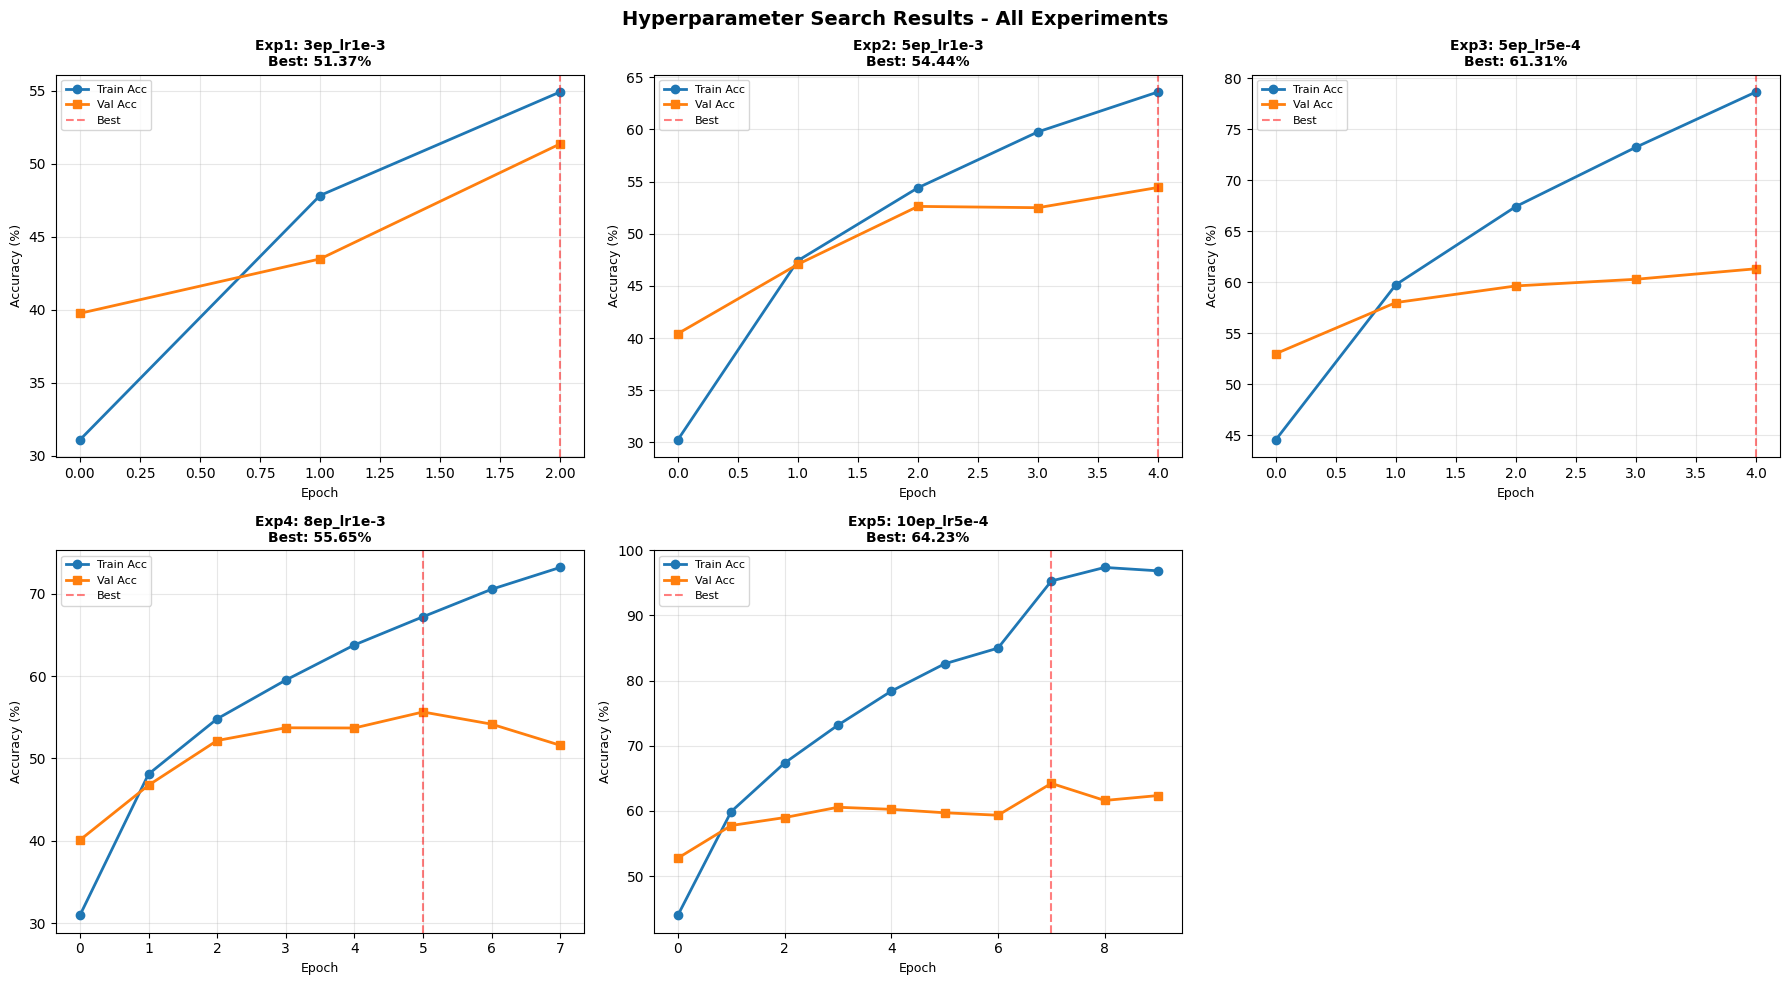

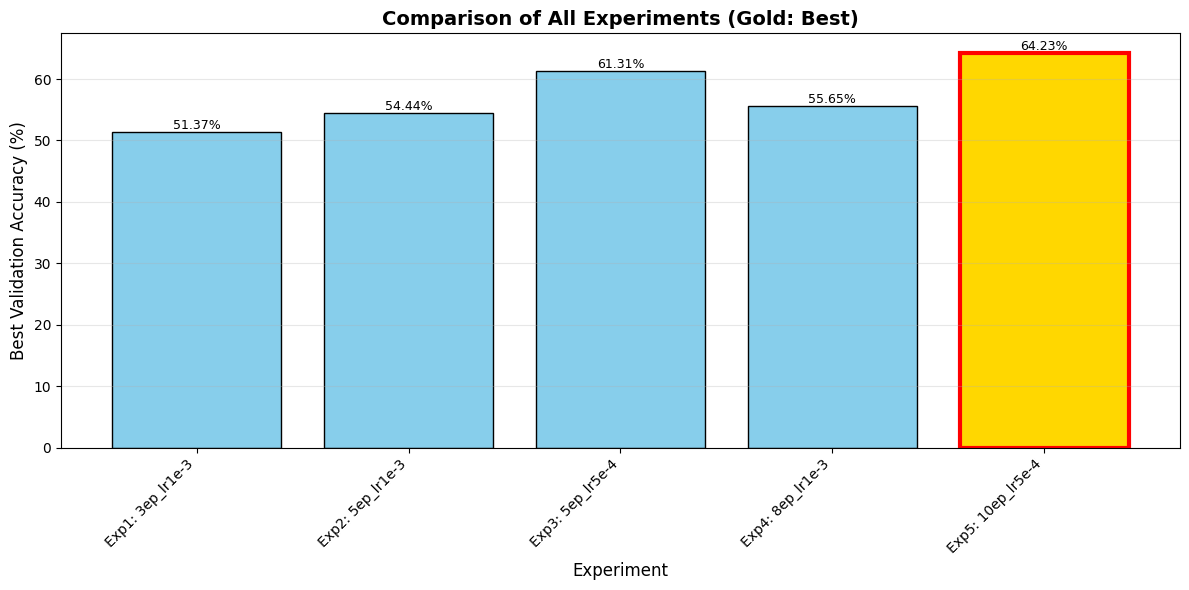

In [51]:
# ============================================================
# 5. 평가 및 시각화
# ============================================================

# --- 5.1: 실험 결과 비교 및 시각화 ---
# 모든 실험의 성능을 비교하고 최적의 파라미터 찾기

print("=" * 70)
print("5.1: 실험 결과 비교")
print("=" * 70)
print()

# 최고 성능 실험 찾기
best_experiment = max(all_experiments, key=lambda x: x['best_val_acc'])

print("[실험 결과 요약]")
print()
print(f"{'실험명':<25} {'에폭':<6} {'학습률':<10} {'최고 검증 정확도':<15} {'소요시간'}")
print("-" * 70)
for exp in all_experiments:
    marker = " ★" if exp == best_experiment else ""
    print(f"{exp['name']:<25} {exp['epochs']:<6} {exp['lr']:<10.0e} "
          f"{exp['best_val_acc']:>6.2f}% (ep{exp['best_epoch']:>2}) "
          f"{exp['elapsed_time']/60:>6.1f}분{marker}")

print()
print(f"[최고 성능 실험]")
print(f"  - 실험명: {best_experiment['name']}")
print(f"  - 에폭: {best_experiment['epochs']}")
print(f"  - 학습률: {best_experiment['lr']}")
print(f"  - 최고 검증 정확도: {best_experiment['best_val_acc']:.2f}% (에폭 {best_experiment['best_epoch']})")
print(f"  - 소요 시간: {best_experiment['elapsed_time']/60:.1f}분")
print()

# 모든 실험의 학습 곡선 시각화 (5개 실험용 레이아웃)
num_experiments = len(all_experiments)
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, exp in enumerate(all_experiments):
    ax = axes[idx]
    history = exp['history']
    
    # 정확도 그래프
    ax.plot(history['train_acc'], marker='o', label='Train Acc', linewidth=2)
    ax.plot(history['val_acc'], marker='s', label='Val Acc', linewidth=2)
    
    # 최고 성능 표시
    best_idx = history['val_acc'].index(max(history['val_acc']))
    ax.axvline(x=best_idx, color='red', linestyle='--', alpha=0.5, label='Best')
    
    ax.set_title(f"{exp['name']}\nBest: {exp['best_val_acc']:.2f}%", 
                 fontsize=10, fontweight='bold')
    ax.set_xlabel('Epoch', fontsize=9)
    ax.set_ylabel('Accuracy (%)', fontsize=9)
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

# 사용하지 않는 subplot 숨기기
for idx in range(num_experiments, len(axes)):
    axes[idx].axis('off')

plt.suptitle('Hyperparameter Search Results - All Experiments', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# 실험 간 비교 막대 그래프
fig, ax = plt.subplots(figsize=(12, 6))
exp_names = [exp['name'] for exp in all_experiments]
best_accs = [exp['best_val_acc'] for exp in all_experiments]

bars = ax.bar(range(len(exp_names)), best_accs, color='skyblue', edgecolor='black')
# 최고 성능 실험 강조
best_idx = all_experiments.index(best_experiment)
bars[best_idx].set_color('gold')
bars[best_idx].set_edgecolor('red')
bars[best_idx].set_linewidth(3)

ax.set_xlabel('Experiment', fontsize=12)
ax.set_ylabel('Best Validation Accuracy (%)', fontsize=12)
ax.set_title('Comparison of All Experiments (Gold: Best)', fontsize=14, fontweight='bold')
ax.set_xticks(range(len(exp_names)))
ax.set_xticklabels(exp_names, rotation=45, ha='right')
ax.grid(True, alpha=0.3, axis='y')

# 값 표시
for i, (bar, acc) in enumerate(zip(bars, best_accs)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{acc:.2f}%', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print("=" * 70)
print()

In [52]:
# --- 5.2: 최종 평가 (테스트 세트) ---
# 최고 성능 실험의 모델로 테스트 세트 평가

print("=" * 70)
print("5.2: 최종 테스트 평가")
print("=" * 70)
print()

# 최고 성능 모델 로드
model = get_model(len(CLASSES))
model.load_state_dict(best_experiment['best_model_state'])
criterion = nn.CrossEntropyLoss()

print(f"  [사용 모델]")
print(f"    - 실험명: {best_experiment['name']}")
print(f"    - 에폭: {best_experiment['epochs']}")
print(f"    - 학습률: {best_experiment['lr']}")
print(f"    - 검증 정확도: {best_experiment['best_val_acc']:.2f}% (에폭 {best_experiment['best_epoch']})")
print()
print("  테스트 세트 평가 중...")

# 테스트 세트 평가
test_loss, test_acc = validate(model, test_loader, criterion, DEVICE)

print()
print("[최종 테스트 결과]")
print(f"  - 테스트 손실: {test_loss:.4f}")
print(f"  - 테스트 정확도: {test_acc:.2f}%")
print()
print(f"  [성능 요약]")
print(f"    - 최고 검증 정확도: {best_experiment['best_val_acc']:.2f}%")
print(f"    - 최종 테스트 정확도: {test_acc:.2f}%")
print(f"    - 성능 차이: {abs(best_experiment['best_val_acc'] - test_acc):.2f}%p")
print()
print("  분석:")
if abs(best_experiment['best_val_acc'] - test_acc) < 3.0:
    print("  [양호] 검증-테스트 성능 차이가 작아 일반화 성능이 우수합니다.")
elif test_acc < best_experiment['best_val_acc']:
    print("  - 테스트 정확도가 검증보다 낮습니다. 약간의 과적합 가능성이 있습니다.")
else:
    print("  [양호] 테스트 정확도가 검증보다 높습니다. 모델이 잘 일반화되었습니다.")

print()
print("[전체 실험 요약]")
print(f"  - 총 실험 수: {len(all_experiments)}개")
print(f"  - 최고 검증 정확도: {best_experiment['best_val_acc']:.2f}%")
print(f"  - 최저 검증 정확도: {min(all_experiments, key=lambda x: x['best_val_acc'])['best_val_acc']:.2f}%")
print(f"  - 성능 개선: {best_experiment['best_val_acc'] - min(all_experiments, key=lambda x: x['best_val_acc'])['best_val_acc']:.2f}%p")
print("=" * 70)
print()

5.2: 최종 테스트 평가

  [사용 모델]
    - 실험명: Exp5: 10ep_lr5e-4
    - 에폭: 10
    - 학습률: 0.0005
    - 검증 정확도: 64.23% (에폭 8)

  테스트 세트 평가 중...


Validation:   0%|          | 0/789 [00:00<?, ?it/s]

RuntimeError: Caught RuntimeError in pin memory thread for device 0.
Original Traceback (most recent call last):
  File "/root/miniconda3/envs/food101/lib/python3.10/site-packages/torch/utils/data/_utils/pin_memory.py", line 43, in do_one_step
    data = pin_memory(data, device)
  File "/root/miniconda3/envs/food101/lib/python3.10/site-packages/torch/utils/data/_utils/pin_memory.py", line 100, in pin_memory
    clone[i] = pin_memory(item, device)
  File "/root/miniconda3/envs/food101/lib/python3.10/site-packages/torch/utils/data/_utils/pin_memory.py", line 66, in pin_memory
    return data.pin_memory(device)
RuntimeError: CUDA error: out of memory
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



In [ ]:
# --- 5.3: 예측 결과 시각화를 위한 역정규화 함수 ---
# 정규화된 이미지 텐서를 원본 픽셀 값 범위로 복원

def denormalize(tensor, mean, std):
    """
    정규화된 이미지 텐서를 역정규화하여 시각화 가능한 형태로 변환
    
    정규화 공식: (x - mean) / std
    역정규화 공식: x * std + mean
    
    Args:
        tensor (torch.Tensor): 정규화된 이미지 텐서 (C, H, W)
        mean (list): 정규화에 사용된 평균값 [R, G, B]
        std (list): 정규화에 사용된 표준편차 [R, G, B]
    
    Returns:
        torch.Tensor: 역정규화된 텐서 (픽셀 값 범위 [0, 1])
    """
    # 텐서 복사 (원본 수정 방지)
    t = tensor.clone()
    
    # 각 채널별로 역정규화 수행
    for i, (m, s) in enumerate(zip(mean, std)):
        t[i] = t[i] * s + m  # 역정규화: x_original = x_normalized * std + mean
    
    # 픽셀 값을 [0, 1] 범위로 제한 (역정규화 시 범위 벗어날 수 있음)
    return torch.clamp(t, 0, 1)

print("=" * 70)
print("5.3: 역정규화 함수 정의 완료")
print("=" * 70)
print("  - 함수명: denormalize()")
print("  - 입력: 정규화된 이미지 텐서 (C, H, W)")
print("  - 출력: 역정규화된 텐서 (픽셀 값 [0, 1])")
print()
print("  [역정규화 공식]")
print(f"    - 정규화: (x - mean) / std")
print(f"    - 역정규화: x * std + mean")
print(f"    - 사용된 mean: {MEAN}")
print(f"    - 사용된 std: {STD}")
print("=" * 70)
print()

In [ ]:
# --- 5.4: 테스트 배치 예측 수행 ---
# 시각화를 위한 샘플 이미지 배치 로드 및 예측

print("=" * 70)
print("5.4: 테스트 배치 예측")
print("=" * 70)
print()

# 모델을 평가 모드로 전환
model.eval()

# 테스트 로더에서 첫 번째 배치 가져오기
images, labels = next(iter(test_loader))

print(f"  - 배치 크기: {images.size(0)}개")
print(f"  - 이미지 형태: {tuple(images.shape)}")
print()

# 예측 수행 (그래디언트 계산 비활성화)
with torch.no_grad():
    # 이미지를 GPU로 이동하여 예측
    outputs = model(images.to(DEVICE))
    
    # 가장 높은 확률의 클래스 선택
    _, preds = outputs.max(1)

# CPU로 이동 (시각화를 위해)
preds = preds.cpu()
outputs = outputs.cpu()

print("  [예측 완료]")
print(f"    - 예측된 샘플 수: {len(preds)}개")
print(f"    - 출력 형태: {tuple(outputs.shape)} (배치크기, 클래스수)")
print()

# 정확도 계산
correct = preds.eq(labels).sum().item()
batch_acc = 100.0 * correct / len(labels)

print(f"  [배치 정확도]")
print(f"    - 정답 수: {correct}/{len(labels)}개")
print(f"    - 배치 정확도: {batch_acc:.2f}%")
print("=" * 70)
print()

In [ ]:
# --- 5.5: 샘플 예측 결과 시각화 ---
# 예측 결과를 이미지와 함께 시각적으로 표시

print("=" * 70)
print("5.5: 샘플 예측 결과 시각화")
print("=" * 70)
print()

# 3x5 그리드로 15개 샘플 표시
fig, axes = plt.subplots(3, 5, figsize=(16, 10))
axes = axes.flatten()

# 정답/오답 카운터
correct_count = 0
incorrect_count = 0

print("  [예측 결과 분석]")
print()

for i, ax in enumerate(axes):
    # 배치 크기보다 많은 인덱스는 빈 셀로 처리
    if i >= len(images):
        ax.axis('off')
        continue
    
    # 이미지 역정규화 및 형태 변환
    img = denormalize(images[i], MEAN, STD)  # (C, H, W) 역정규화
    img = img.permute(1, 2, 0).cpu().numpy()  # (H, W, C)로 변환
    
    # 실제 레이블과 예측 레이블
    true_cls = IDX_TO_CLASS[labels[i].item()]
    pred_cls = IDX_TO_CLASS[preds[i].item()]
    
    # 예측 확률 계산 (Softmax)
    probs = torch.softmax(outputs[i], dim=0)
    pred_prob = probs[preds[i]].item() * 100  # 예측 클래스의 확률
    
    # 정답 여부에 따라 색상 설정
    is_correct = (true_cls == pred_cls)
    color = 'green' if is_correct else 'red'
    
    # 카운터 업데이트
    if is_correct:
        correct_count += 1
    else:
        incorrect_count += 1
    
    # 이미지 및 레이블 표시
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(
        f"True: {true_cls}\nPred: {pred_cls} ({pred_prob:.1f}%)",
        color=color,
        fontsize=9,
        fontweight='bold'
    )
    
    # 처음 3개의 오답 케이스 출력
    if not is_correct and incorrect_count <= 3:
        print(f"  [오답] 샘플 {i+1}:")
        print(f"      실제: {true_cls}")
        print(f"      예측: {pred_cls} (확률: {pred_prob:.1f}%)")
        # Top-3 예측 출력
        top3_probs, top3_indices = probs.topk(3)
        print(f"      Top-3 예측:")
        for rank, (prob, idx) in enumerate(zip(top3_probs, top3_indices), 1):
            print(f"        {rank}. {IDX_TO_CLASS[idx.item()]} ({prob.item()*100:.1f}%)")
        print()

# 그래프 제목 및 레이아웃 조정
plt.suptitle(
    'Sample Prediction Results (Green: Correct, Red: Incorrect)',
    fontsize=14,
    fontweight='bold'
)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

print()
print(f"  [시각화 통계]")
print(f"    - 표시된 샘플: {min(15, len(images))}개")
print(f"    - 정답: {correct_count}개 (초록색)")
print(f"    - 오답: {incorrect_count}개 (빨간색)")
print(f"    - 정확도: {100*correct_count/min(15, len(images)):.1f}%")
print()
print("  [범례]")
print("    - 초록색 제목: 올바른 예측")
print("    - 빨간색 제목: 잘못된 예측")
print("    - 괄호 안 숫자: 예측 확률 (%)")
print("=" * 70)
print()